In [1]:
import os

from PIL import Image
import skimage.io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def psnr(original, decoded):
    mse = np.mean(np.power(original - decoded, 2))
    if(mse == 0):
        return np.inf
    max_val = 255.0
    psnr = 20 * np.log10(max_val / np.sqrt(mse))
    return psnr

In [55]:
model_name = "default"

my_coords = {}
jpg_coords = {}

filenames = ["lena", "baboon", "peppers"]

for filename in filenames:
    my_coords[filename] = []
    for B in [1, 2, 4, 6]:
        image_path = fr"compression-lab-imgs\{filename}.png"
        encode_output_path = fr"compression-lab-imgs\{filename}_B{B}.neural"
        compressor_state_path = fr"compression-lab-imgs\{filename}_B{B}_state.json"
        decode_output_path = fr"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"

        orig_img_np = skimage.io.imread(image_path)
        n_pixels = np.prod(orig_img_np.shape[:2])

        !python encode.py -i {image_path} -B {B} -s {compressor_state_path} -o {encode_output_path} -m {model_name}
        !python decode.py -i {encode_output_path} -B {B} -s {compressor_state_path} -o {decode_output_path}  -m {model_name}

        my_img_np = skimage.io.imread(decode_output_path)
        my_psnr = psnr(orig_img_np, my_img_np)
        my_bpp = os.path.getsize(encode_output_path) * 8 / n_pixels
        my_coords[filename].append((my_bpp, my_psnr))


    jpg_coords[filename] = []
    orig_img = Image.fromarray(orig_img_np)
    jpg_qualities = [10, 20, 45, 75] if filename == 'baboon' else [30, 50, 80, 90]
    for jpg_quality in jpg_qualities:
        jpg_path = fr"compression-lab-imgs\{filename}_q{jpg_quality}.jpg"
        orig_img.save(jpg_path, "JPEG", quality=jpg_quality, optimize=True, progressive=True)
        
        jpg_np = skimage.io.imread(jpg_path)
        jpg_psnr = psnr(orig_img_np, jpg_np)
        jpg_bpp = os.path.getsize(jpg_path) * 8 / n_pixels
        jpg_coords[filename].append((jpg_bpp, jpg_psnr))

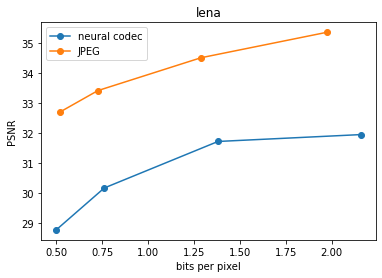

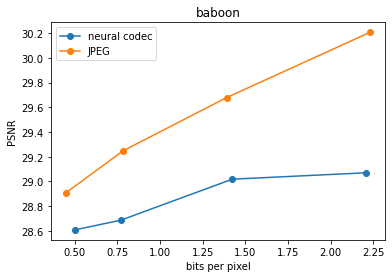

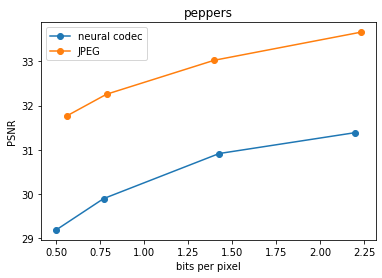

In [57]:
for filename in filenames:
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_title(filename)
    ax.set_xlabel('bits per pixel')
    ax.set_ylabel('PSNR')
    my_bpps, my_psnrs = list(zip(*my_coords[filename]))
    plt.plot(my_bpps, my_psnrs, marker = 'o')
    plt.plot(*list(zip(*jpg_coords[filename])), marker = 'o')
    ax.legend(["neural codec", "JPEG"])

    # txts = ["B1", "B2", "B4", "B6"]
    # for i, txt in enumerate(txts):
    #     ax.annotate(txt, (my_bpps[i], my_psnrs[i]))

    plt.show()


In [58]:
my_coords

{'lena': [(0.500030517578125, 28.784197821579724),
  (0.76202392578125, 30.17866468372941),
  (1.38140869140625, 31.725461350527873),
  (2.15753173828125, 31.953663278343825)],
 'baboon': [(0.500030517578125, 28.607308937246707),
  (0.7708740234375, 28.686142560534662),
  (1.42352294921875, 29.017844784891047),
  (2.203857421875, 29.06950867257311)],
 'peppers': [(0.500030517578125, 29.18953759989149),
  (0.7694091796875, 29.897109046153417),
  (1.426055908203125, 30.915496350800105),
  (2.19476318359375, 31.385046379063045)]}

In [59]:
jpg_coords

{'lena': [(0.521026611328125, 32.705530811829455),
  (0.727081298828125, 33.41673651113285),
  (1.2884521484375, 34.50897506399223),
  (1.975494384765625, 35.35724122997543)],
 'baboon': [(0.44830322265625, 28.906541518277553),
  (0.782257080078125, 29.246342804934976),
  (1.389862060546875, 29.677886088213604),
  (2.23095703125, 30.20682970927162)],
 'peppers': [(0.561798095703125, 31.76813141238712),
  (0.7861328125, 32.25515347132694),
  (1.397918701171875, 33.0224531674405),
  (2.228851318359375, 33.65550539396375)]}

In [8]:
import os

from PIL import Image
import skimage.io
import numpy as np
import matplotlib.pyplot as plt

from looseless_compressors import Huffman 

from decoder_pipeline import (decoder_pipeline,
                              get_quant_error_normal,
                              get_zero_noise,
                              get_quant_error_uniform)

from trained_models import get_decoder

from encoder_pipeline import encoder_pipeline
from trained_models import get_encoder





from typing import List
import os

import torch
import numpy as np
from PIL import Image

from trained_models import get_decoder
from looseless_compressors import LooselessCompressor, Huffman
from decoder_pipeline import denormalize_imagenet, decode_binary_file, torch_img_to_np_img

In [37]:
# Encoder doesn't output values below 0.2

model_name = "default"
filenames = ["lena", "baboon", "peppers"]

for filename in filenames:
    image_path = fr"compression-lab-imgs\{filename}.png"

    orig_img_np = skimage.io.imread(image_path)
    n_pixels = np.prod(orig_img_np.shape[:2])
    looseless_compressor = Huffman()

    encoder = get_encoder(model_name, B)
    encoder_out, binary_string = encoder_pipeline(
        encoder, image_path, B,
        compressor_state_path = None,
        compressed_img_path = None,
        looseless_compressor = looseless_compressor)
    
    thresh = 0.4
    n_els_grater_than_lim = 0
    for i in encoder_out.flatten():
        if i > thresh:
            n_els_grater_than_lim += 1
    print(n_els_grater_than_lim)
    print(encoder_out.flatten().shape[0] == n_els_grater_than_lim)

131072
True
131072
True
131072
True


In [40]:
def test_quantization_and_noise(model_name, filename, B_list, get_noise, quantize: bool, title):
    for B in B_list:
        image_path = fr"compression-lab-imgs\{filename}.png"
        # encode_output_path = fr"compression-lab-imgs\{filename}_B{B}.neural"
        # compressor_state_path = fr"compression-lab-imgs\{filename}_B{B}_state.json"
        # decode_output_path = fr"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"

        orig_img_np = skimage.io.imread(image_path)
        n_pixels = np.prod(orig_img_np.shape[:2])
        looseless_compressor = Huffman()

        encoder = get_encoder(model_name, B)
        encoder_out, binary_string = encoder_pipeline(
            encoder, image_path, B,
            compressor_state_path = None,
            compressed_img_path = None,
            looseless_compressor = looseless_compressor)

        decoder = get_decoder(model_name, B)
        decoder.eval()

        if quantize:
            binary_list = looseless_compressor.decode(binary_string)
            quantized = torch.tensor(binary_list)
            dequantized = quantized / 2**B
            height = width = int((len(dequantized)/decoder.in_channels)**0.5)

            decoder_input = dequantized.reshape(
                1, decoder.in_channels, height, width)
        else:
            decoder_input = encoder_out

        decoded_tensor_imagenet_norm = decoder(
            decoder_input + get_noise(decoder_input.shape, B))

        decoded_tensor = denormalize_imagenet(
            decoded_tensor_imagenet_norm.squeeze(0))
        
        my_img_np = torch_img_to_np_img(decoded_tensor)

        my_psnr = psnr(orig_img_np, my_img_np)
        # my_bpp = os.path.getsize(encode_output_path) / n_pixels
        # Since last bit is always 1 (it's seq_end indicator) we remove it.
        my_bpp = len(binary_string[:-1]) / n_pixels

        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot()
        ax.set_title(f"{title}\nB = {B}, psnr = {my_psnr:.3f}, bpp = {my_bpp:.3f}")
        plt.imshow(my_img_np)
        plt.axis('off')
        plt.show()

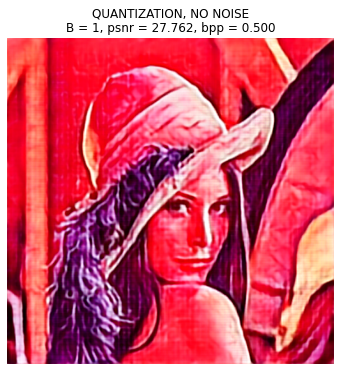

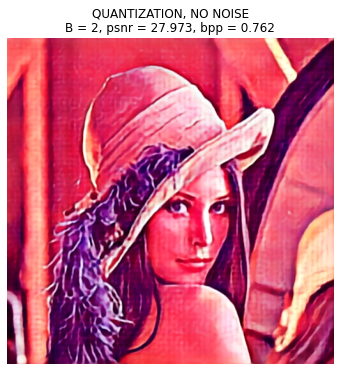

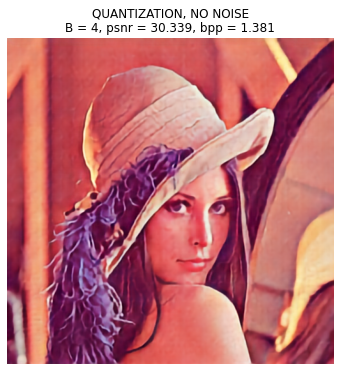

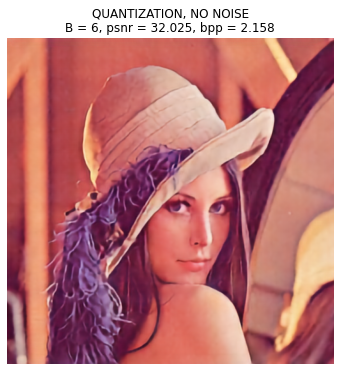

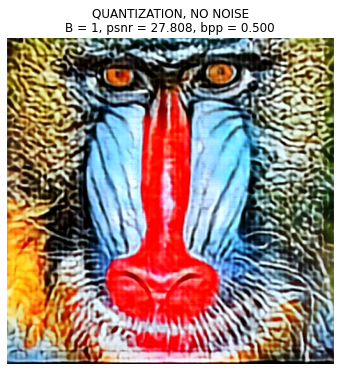

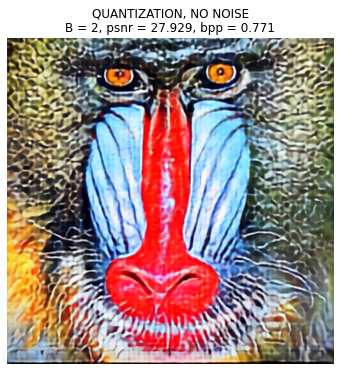

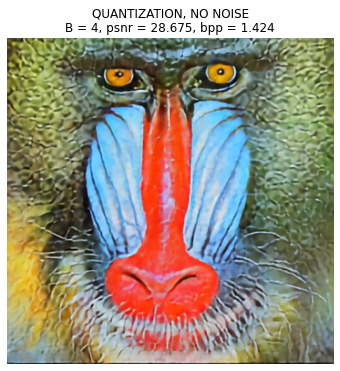

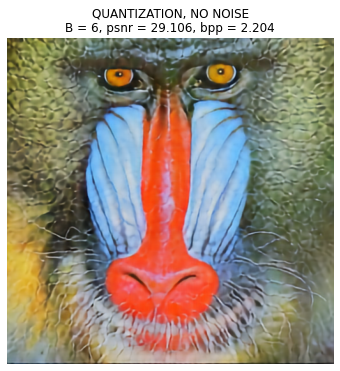

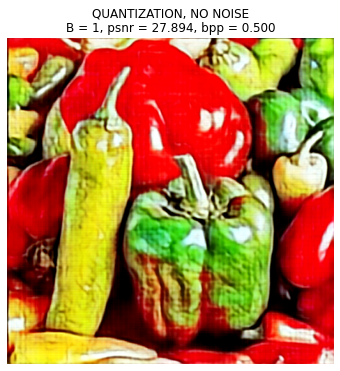

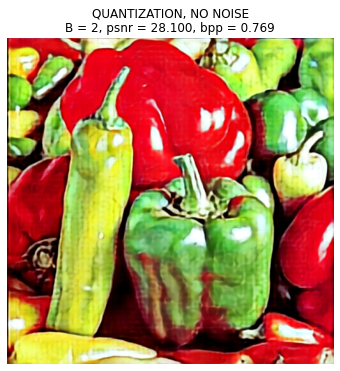

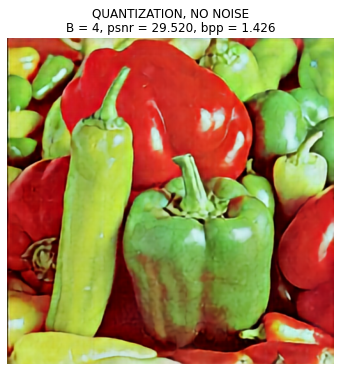

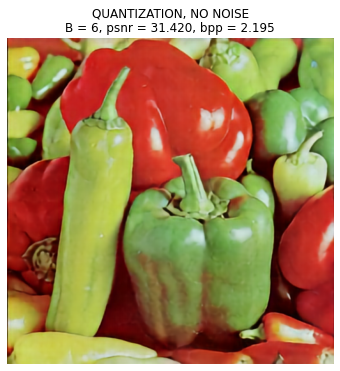

In [42]:
filenames = ["lena", "baboon", "peppers"]

for filename in filenames:
    test_quantization_and_noise(
        model_name = "default", filename=filename,
        B_list = [1, 2, 4, 6], get_noise=get_zero_noise,
        quantize=True, title = "QUANTIZATION, NO NOISE")

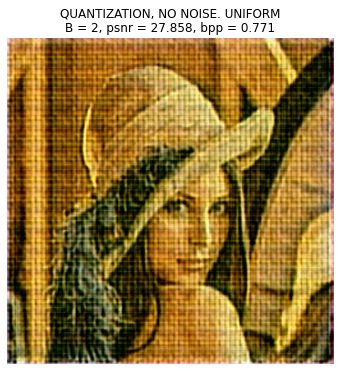

In [14]:
test_quantization_and_noise(model_name = "resnet18x32__512ch__abs__relu__no_last_activation__uniform_noise",
                            filename="lena", B_list = [2], get_noise=get_zero_noise,
                            quantize=True, title = "QUANTIZATION, NO NOISE. UNIFORM")

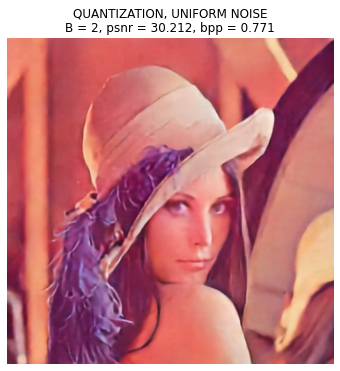

In [15]:
test_quantization_and_noise(model_name = "resnet18x32__512ch__abs__relu__no_last_activation__uniform_noise",
                            filename="lena", B_list = [2], get_noise=get_quant_error_uniform,
                            quantize=True, title = "QUANTIZATION, UNIFORM NOISE")

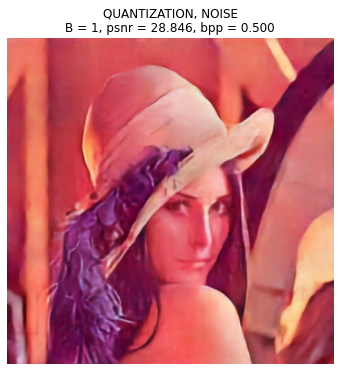

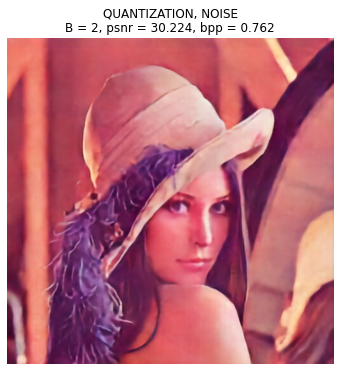

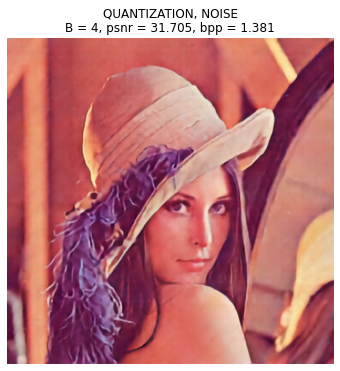

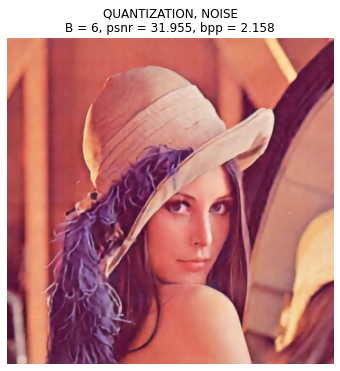

In [17]:
test_quantization_and_noise(model_name = "default",
                            filename="lena",
                            B_list = [1, 2, 4, 6],
                            get_noise=get_quant_error_normal,
                            quantize=True,
                            title = "QUANTIZATION, NOISE")

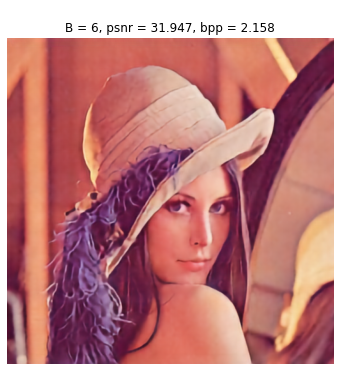

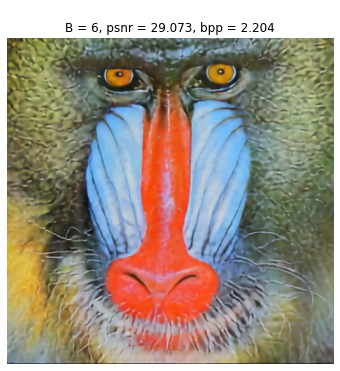

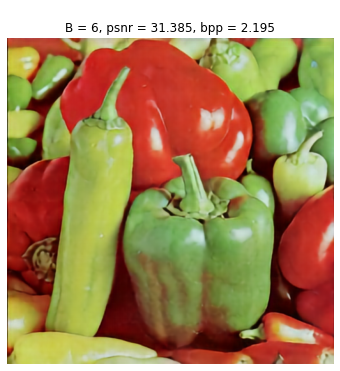

In [61]:
for filename in filenames:
    test_quantization_and_noise(model_name = "default",
                                filename=filename,
                                B_list = [6],
                                get_noise=get_quant_error_normal,
                                quantize=True,
                                title = "")

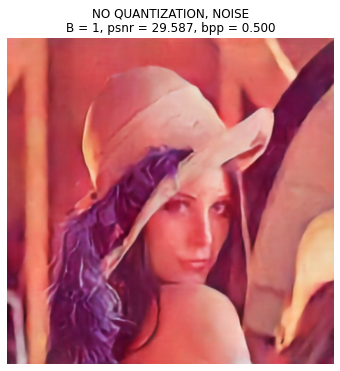

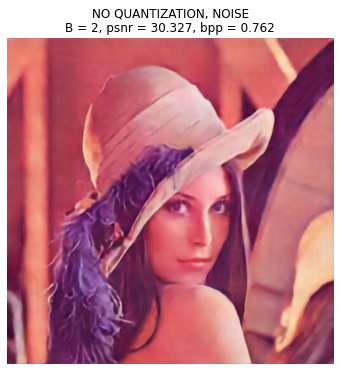

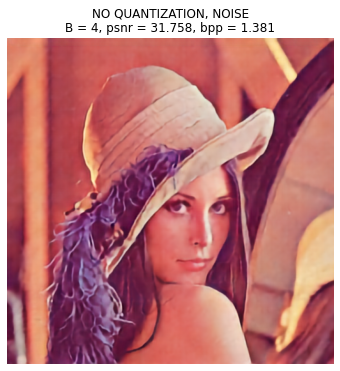

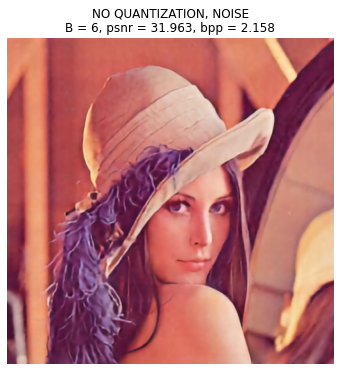

In [18]:
test_quantization_and_noise(model_name = "default",
                            filename="lena",
                            B_list = [1, 2, 4, 6],
                            get_noise=get_quant_error_normal,
                            quantize=False,
                            title = "NO QUANTIZATION, NOISE")

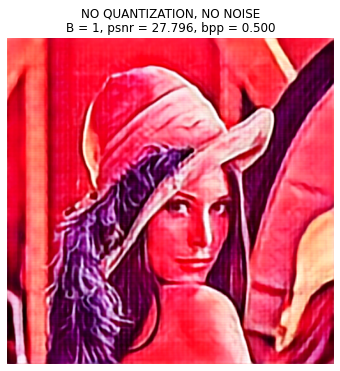

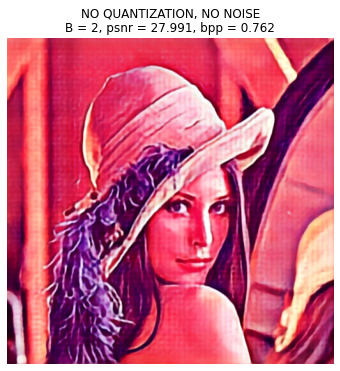

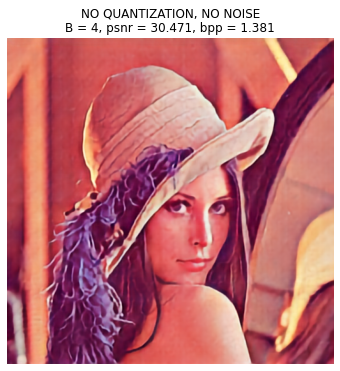

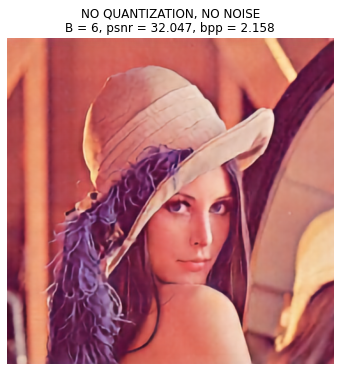

In [20]:
test_quantization_and_noise(model_name = "default",
                            filename="lena",
                            B_list = [1, 2, 4, 6],
                            get_noise=get_zero_noise,
                            quantize=False,
                            title = "NO QUANTIZATION, NO NOISE")

In [ ]:
my_img 
my_psnr = psnr(orig_img_np, my_img_np)
# my_bpp = os.path.getsize(encode_output_path) / n_pixels
# Since last bit is always 1 (it's seq_end indicator) we remove it.
my_bpp = len(binary_string[:-1]) / n_pixels

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.set_title(f"{title}\nB = {B}, psnr = {my_psnr:.3f}, bpp = {my_bpp:.3f}")
plt.imshow(my_img_np)
plt.axis('off')
plt.show()

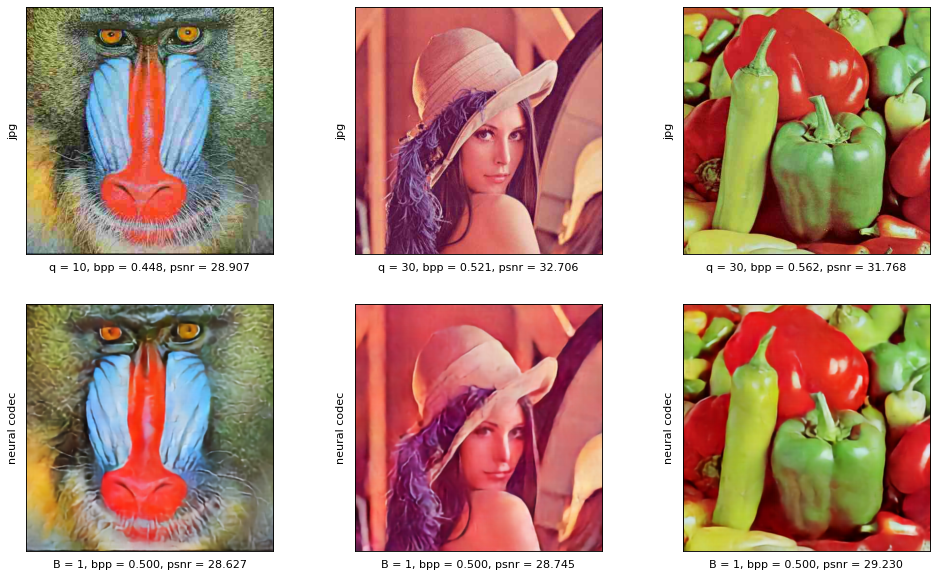

In [88]:
B = 1

# filename_to_q = {
#     'lena': 90,
#     'baboon': 70,
#     'peppers': 90
# }

filename_to_q = {
    'lena': 30,
    'baboon': 10,
    'peppers': 30
}

file_names = ['baboon', 'lena', 'peppers']

fig, axs = plt.subplots(2, 3, dpi=80)

for i, filename in enumerate(file_names):
    orig_img_path = f"compression-lab-imgs\{filename}.png"
    orig_np = skimage.io.imread(orig_img_path)
    n_pixels = np.prod(orig_np.shape[:2])
    
    my_image_path = f"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"
    my_compressed_path = f"compression-lab-imgs\{filename}_B{B}.neural"
    my_np = skimage.io.imread(my_image_path)
    my_bpp = os.path.getsize(my_compressed_path) * 8 / n_pixels
    
    q = filename_to_q[filename]
    jpg_path = f"compression-lab-imgs\{filename}_q{q}.jpg"
    jpg_np = skimage.io.imread(jpg_path)
    jpg_bpp = os.path.getsize(jpg_path) * 8 / n_pixels
    
    axs[0, i].imshow(jpg_np)
    axs[1, i].imshow(my_np)
    
    axs[0, i].set(xlabel=f'q = {q}, bpp = {jpg_bpp:.3f}, psnr = {psnr(orig_np, jpg_np):.3f}', ylabel="jpg" )
    axs[1, i].set(xlabel=f'B = {B}, bpp = {my_bpp:.3f}, psnr = {psnr(my_np, jpg_np):.3f}',ylabel="neural codec")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    # ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

fig.set_size_inches(15,9)  # double the default size

plt.show()